In [7]:
!pip install opencv-python
!pip install --upgrade tensorflow-hub

  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)


# Import libraries

In [15]:
# Importing libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img
import seaborn as sns
import pandas as pd
from IPython.display import IFrame
#from io import BytesIO
from numpy import random
from PIL import ImageFile
from scipy import signal
from scipy import ndimage
from scipy.ndimage import filters
from skimage import data
import cv2
from tqdm.notebook import tqdm
import time
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
import os
import pathlib
import matplotlib
import io

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [10]:
def load_plot(im_name):
    x1, y1, x2, y2 = train_annotation.loc[train_annotation["im_name"] == im_name].iloc[0, 1:5]
    im = np.asanyarray(Image.open(f"../datasets/datasets_train/train/{im_name}"))
    
    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
    )

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()
   

def get_output_of_prediction(prediction, height, width):
    classes = prediction['detection_classes'].numpy().astype('int')[0]
    boxes = prediction["detection_boxes"].numpy()
    scores = prediction["detection_scores"].numpy()
    best_car_score = 0
    best_box = None
    for score,(ymin,xmin,ymax,xmax) , label in zip(scores[0], boxes[0], classes):
        if score > 0.4:
            if category_to_label[label] == "car":# or  category_to_label[label] == "truck" :
                if score > best_car_score : 
                    best_car_score = score
                    best_box = (ymin,xmin,ymax,xmax)
    
    if best_box : 
        ymin,xmin,ymax,xmax = best_box
        return xmin * width ,ymin * height, xmax * width , ymax * height, best_car_score
    else:
        return np.nan ,np.nan, np.nan , np.nan, np.nan

def get_image_path(path):
    imagee = Image.open(path)
    im = np.asanyarray(imagee)
    rgb_tensor = tf.convert_to_tensor(im, dtype=tf.uint8)
    #Add dims to rgb_tensor
    rgb_tensor = tf.expand_dims(rgb_tensor , 0)
    return rgb_tensor

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2
    intersect_w = _interval_overlap([xmin1, xmax1], [xmin2, xmax2])
    intersect_h = _interval_overlap([ymin1, ymax1], [ymin2, ymax2])
    intersect = intersect_w * intersect_h
    w1, h1 = xmax1-xmin1, ymax1-ymin1
    w2, h2 = xmax2-xmin2, ymax2-ymin2
    union = w1*h1 + w2*h2 - intersect
    iou =  float(intersect) / union
    if iou != iou :
        return 0
    return iou

# Load datasets

In [2]:
train_annotation = pd.read_csv(f"../datasets/datasets_train/train_annotation/_annotation.csv",delimiter=',',index_col=0)
train_annotation.dropna(inplace=True)
train_annotation.loc[(train_annotation["class"] != 'car'),['x_min','y_min','x_max','y_max']]=np.nan
train_annotation.loc[(train_annotation["class"] != 'car'),"class"] = "Not_car"
train_annotation.head()

,im_name,x_min,y_min,x_max,y_max,class,models
0,107347968.jpg,40.0,244.0,1144.0,637.0,car,Audi S5 Convertible 2012
1,91160576.jpg,4.0,9.0,98.0,76.0,car,Audi 100 Wagon 1994
2,273809408.jpg,16.0,4.0,288.0,191.0,car,Cadillac SRX SUV 2012
3,579534848.jpg,14.0,23.0,255.0,178.0,car,Ford Freestar Minivan 2007
4,950599680.jpg,4.0,70.0,321.0,215.0,car,Rolls-Royce Phantom Sedan 2012


In [3]:
try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:0'):
    for img in train_annotation["im_name"]:
        # define our new photo
        photo_filename = f"../datasets/datasets_train/train/{img}"
        # load and prepare image
        
        try:
            img1 = Image.open(photo_filename)
            np.asarray(img1)
        except Exception as e: 
            print("Error in loading the image {}".format(img))
            train_annotation.drop(train_annotation[train_annotation["im_name"] == img].index,inplace=True)
except RuntimeError as e:
  print(e)

Error in loading the image 309637115.jpg
Error in loading the image 5608441012.jpg
Error in loading the image 5467077179.jpg
Error in loading the image 6072090028.jpg


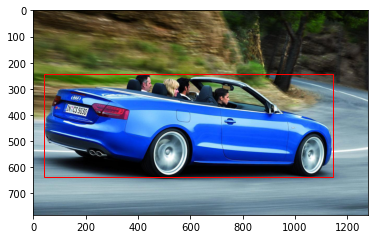

In [11]:
load_plot("107347968.jpg")

# Preprocessing

### Transform data into cars and non cars

In [6]:
# split data to car and non car
train_annotation['class'] = np.where(train_annotation['class'] == 'car', "car", "non car")

### Save images with labels

In [18]:
DIR="../datasets/datasets_train/train/"
images_path= train_annotation["im_name"].values
images_labels = train_annotation["models"].values
images_train = []
images_train_labels = []
for i in range(len(images_path)):
    try:
        image = Image.open(DIR+images_path[i])
        image = image.resize((416, 416))
        image = np.asarray(image)
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        images_train.append(image)
        images_train_labels.append(images_labels[i])
    except:
        continue

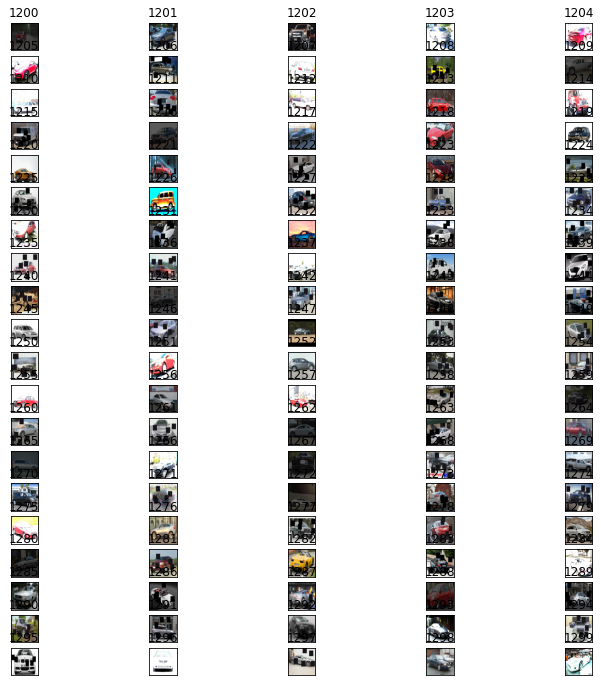

In [27]:
# visualize images
rows = 20
_ = plt.figure(figsize=(12, 12))
cols = 100//rows if 100 % 2 == 0 else 100//rows + 1
for i in range(100):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images_train[1200+i],cmap="gray")
    plt.title(str(1200+i))
    plt.xticks([])
    plt.yticks([])

### Remove black boxes

In [12]:
def remove_black_box(im):
    median = cv2.medianBlur(im,5)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    a= 1*(gray <25)
    a=a.astype('uint8')
    kernel = np.ones((20,20),np.uint8)
    erode = cv2.erode(a,kernel,iterations = 1)
    kernel = np.ones((35,30),np.uint8)
    dilation = cv2.dilate(erode,kernel,iterations = 1)
    mask = dilation
    dst = cv2.inpaint(im,mask,20,cv2.INPAINT_TELEA)
    return dst

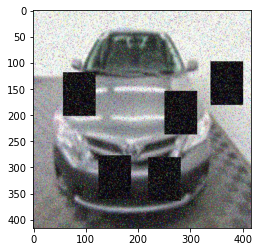

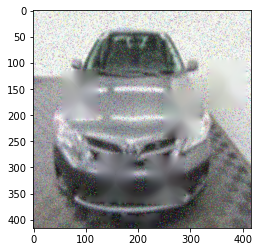

In [32]:
im = images_train[1261]
plt.imshow(im)
plt.show()
plt.imshow(remove_black_box(im))
plt.show()

### EffecientNet model : 

In [ ]:
#Loading the object detection model downloaded from tensorflowHub 
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/d2/1")

In [13]:
#Mapping category numbers to labels
category_to_label = pd.read_csv('labels.csv', sep=';', index_col='ID')
category_to_label = category_to_label['OBJECT (2017 REL.)']

## Trying the model on one image : 

In [16]:
s=time.time()

im = load_img(f"../datasets/datasets_train/train/83230720.jpg")
rgb_tensor = tf.convert_to_tensor(im, dtype=tf.uint8)
#Add dims to rgb_tensor
rgb_tensor = tf.expand_dims(rgb_tensor , 0)
# running inference
res = detector(rgb_tensor)
xmin, ymin, xmax, ymax, score = get_output_of_prediction(res, imagee.size[1], imagee.size[0])   

print(time.time()-s)

NameError: name 'detector' is not defined